# Polynomial Chaos Expansion

### Example 1: gPCE for a Uniform RV
Consider a model function $f(q)$, where $q\sim\mathcal{U}[a,b]$. The aim is to apply gPCE to estimate $\mathbb{E}_q[f(q)]$ and $\mathbb{V}_q[f(q)]$ and also construct a surrogate $\tilde{f}(q)$. These values will be compared to exact analytical values to validate the implementation in UQit.

In particular, we consider 
$$
\begin{equation}
r=10+0.7\sin(5q)+3 \cos(q)
\end{equation}
$$

which is availble from `analyticTestFuncs.fEx1D(qNodes,'type1')`.

In [1]:
import os
import sys
import numpy as np
import math as mt
import matplotlib
import matplotlib.pyplot as plt
sys.path.append(os.getenv("UQit"))
import pce
import analyticTestFuncs

**Step 1:** Set the general settings

In [2]:
distType='Unif'   #distribution type of the parameter
qBound=[-2,4.0]   #parameter range
n=10               #number of training samples
nTest=200         #number of test sample sin the parameter space

Set the PCE settings

In [3]:
sampleType='GQ'    #'GQ'=Gauss Quadrature nodes
                   #''= any other sample => only 'Regression' can be selected
pceSolveMethod='Projection' #'Regression': for any combination of sample points 
                            #'Projection': only for GQ
LMax_=10   #(Only needed for 'Regresson' method), =K: truncation (num of terms) in PCE
           #(LMax will be over written by nSamples if it is provided for 'GQ'+'Projection')
           #NOTE: LMAX>=nSamples

**Step 2:** Put together the PCE information in `pceDict`. If some of the options are wrongly set by the user, `pceDict_corrector` will correct it. 

In [4]:
pceDict={'sampleType':sampleType,'pceSolveMethod':pceSolveMethod,'LMax':LMax_,
         'distType':distType}
pceDict=pce.pceDict_corrector(pceDict)

**Step 3:** Generate training samples. We choose the samples to be Gauss-quadrature nodes. 

In [5]:
xi,w=pce.gqPtsWts(n,distType)   

**Step 4:** Run the simulators at te training samples. 

In [6]:
q=pce.map_xi2q(xi,qBound,distType)
f=analyticTestFuncs.fEx1D(q,'type1')

**Step 5** Construct the PCE, given the training data.

In [7]:
fCoef,fMean,fVar=pce.pce_1d_cnstrct(f,xi,pceDict)  

The outputs are the coefficients in the PCE along with the estimated $\mathbb{E}_q[f(q)]$ and  $\mathbb{V}_q[f(q)]$. 

**Step 6:** Validate the PCE_estimated moments with associated analytical values. 

In [8]:
fMean_ex,fVar_ex=analyticTestFuncs.fEx1D_moments(qBound,'type1')
print('--------- Exact --------- PCE ---- Error % ')
print('E[(q)] = %g\t%g\t%g' %(fMean_ex,fMean,(fMean-fMean_ex)/fMean_ex*100.))
print('V[f(q)] = %g\t%g\t%g' %(fVar_ex,fVar,(fVar-fVar_ex)/fVar_ex*100.))

--------- Exact --------- PCE ---- Error % 
E[(q)] = 10.0471	10.056	0.0882092
V[f(q)] = 4.91876	5.05353	2.73999


**Step 7:** Visually comapre the PCE surrogate with the actual simulator at a set of test samples taken from the considered parameter range. First, we generate test points and the value of the simulator. 

In [9]:
qTest=np.linspace(qBound[0],qBound[1],nTest)  #test points in param space
xiTest=pce.mapToUnit(qTest,qBound)
fTest=pce.analyticTestFuncs.fEx1D(qTest,'type1')

Evaluate the constructed PCE at the test points.

In [10]:
fPCE=pce.pce_1d_eval(fCoef,xiTest,distType)

Plot the PCE and exact values:

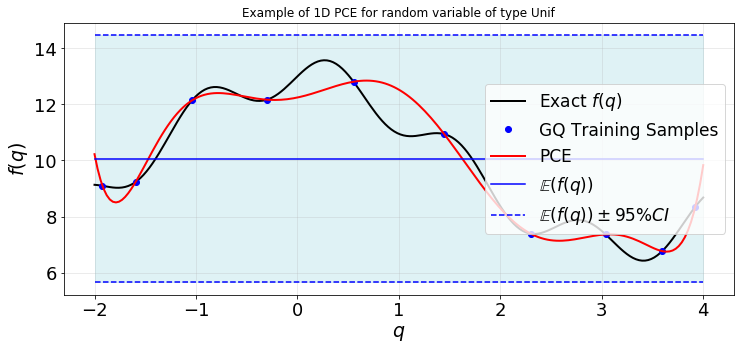

In [11]:
plt.figure(figsize=(12,5))
ax=plt.gca()
plt.plot(qTest,fTest,'-k',lw=2,label=r'Exact $f(q)$')
plt.plot(q,f,'ob',label=sampleType+' Training Samples')
plt.plot(qTest,fPCE,'-r',lw=2,label='PCE')
plt.plot(qTest,fMean*np.ones(len(qTest)),'-b',label=r'$\mathbb{E}(f(q))$')
ax.fill_between(qTest,fMean+1.96*mt.sqrt(fVar)*np.ones(len(qTest)),fMean-1.96*mt.sqrt(fVar)*np.ones(len(qTest)),color='powderblue',alpha=0.4)
plt.plot(qTest,fMean+1.96*mt.sqrt(fVar)*np.ones(len(qTest)),'--b',label=r'$\mathbb{E}(f(q))\pm 95\%CI$')
plt.plot(qTest,fMean-1.96*mt.sqrt(fVar)*np.ones(len(qTest)),'--b')
plt.title('Example of 1D PCE for random variable of type %s' %distType)
plt.xlabel(r'$q$',fontsize=19)
plt.ylabel(r'$f(q)$',fontsize=19)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(alpha=0.3)
plt.legend(loc='best',fontsize=17)

**Further Practice:**
1. Try to change number of trainging samples and look at the convergence of the moments and above figure. 
2. Instead of `Projection` method to compute the PCE coeffcients, try `Regression`. 
3. Instead of Gauss-quadrature nodes, try uniformly-spaced, random, ... training samples for the parameter. 

### Example 2: gPCE for a Normal RV